<a href="https://colab.research.google.com/github/mdpatel2/MSAAI-521/blob/main/MSAAI_521_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project outline

1. Resize all of the images --> DONE
2. Using the directory names as labels, create a tfrecord file. --> DONE
3. Create a dataset from the tfrecord file. --> DONE
4. Display one image from the dataset. --> DONE
5. Split the dataset into test and train sets. --> DONE
6. Create the CNN.
7. Train the model.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Inspecting the image set

In [3]:
import os, shutil, io
from tqdm import tqdm
from pathlib import Path
import pandas as pd
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import IPython.display as display
import tensorflow as tf

In [36]:
# how many images are there?
kaggle_dir = "/content/drive/MyDrive/kaggle/images"
kaggle_img_paths = list(Path(kaggle_dir).glob('*/*.jpg'))
ds_size = len(kaggle_img_paths)
ds_size

101000

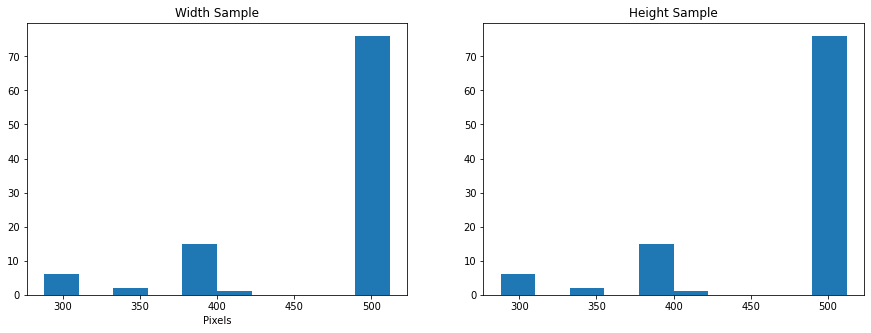

In [46]:
# what is the shape profile of the image set
import random

w, h = [], []
for path in random.sample(kaggle_img_paths, 100):
  image_orig = cv.imread(str(path))
  w.append(image_orig.shape[0])
  h.append(image_orig.shape[0])

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))
ax1.hist(w)
ax1.set_title("Width Sample")
ax1.set_xlabel("Pixels")
ax2.hist(h)
ax2.set_title("Height Sample")
ax1.set_xlabel("Pixels");

In [48]:
print(f"Min Width: {min(w)} Max Width: {max(w)} Avg Width: {sum(w)/len(w):.2f}")
print(f"Min Height: {min(w)} Max Height: {max(w)} Avg Height: {sum(w)/len(w):.2f}")

Min Width: 288 Max Width: 512 Avg Width: 474.95
Min Height: 288 Max Height: 512 Avg Height: 474.95


# Resizing the images

In [8]:
#get full path of all kaggle subdirectories
kaggle_img_dir, kaggle_sub_dirs, _  = next(os.walk(kaggle_dir))
kaggle_img_paths = [os.path.join(kaggle_img_dir, subdir)for subdir in kaggle_sub_dirs]

In [9]:
#how many classes are there
len(kaggle_img_paths)

101

In [10]:
#make new local subdirectories as dest_dir/subdir
dest_dir = "imgs_for_dataset"
dest_sub_dirs = kaggle_sub_dirs
dest_sub_paths = [dest_dir + "/" + subdir for subdir in dest_sub_dirs]
for path in dest_sub_paths:
  os.makedirs(path, exist_ok=True)

In [11]:
# this dataframe will capture some useful info for later 
meta_df = pd.DataFrame(columns=["filename", "label", "path"])

In [12]:
def resize(src_path):
  img_orig = cv.imread(src_path)
  return cv.resize(img_orig, dsize=(512,512))

In [ ]:
#for each kaggle image subdir
total = 0
for subdir in tqdm(kaggle_sub_dirs):
  kaggle_sub_path = Path(os.path.join(kaggle_img_dir, subdir))
  #get the filenames and full path of images
  img_names = os.listdir(kaggle_sub_path)
  kaggle_img_paths = list(kaggle_sub_path.glob('*.jpg'))
  #copy the image to the destination directory
  for i,kaggle_img_path in enumerate(kaggle_img_paths):
    dest_path = dest_dir + "/" + subdir + "/" + img_names[i]
    new_row = {'filename': img_names[i], 'label': subdir, 'src_path': kaggle_img_path, 'path': dest_path}
    meta_df = meta_df.append(new_row, ignore_index=True)
    img_resized = resize(str(kaggle_img_path))
    cv.imwrite(dest_path, img_resized)

In [14]:
len(meta_df.index)

101000

# Make the TFRecord file

From https://www.tensorflow.org/tutorials/load_data/tfrecord

Each record in the TFRecord file is called an *observation* or *example*. Examples are {"string": tf.train.Feature} mapping. The tf.train.Feature is a that protocol buffer message type can accept one of three types. Most other generic types can be coerced into one of these. The following are helper functions that convert integer and string features into their respective train.Feature compatible types.

In [17]:
## type conversion helper functions
def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

In [18]:
# create example message
def image_example(image_string, label):
  feature = {
      'label': _bytes_feature(label),
      'image_raw': _bytes_feature(image_string)
  }
  return tf.train.Example(features=tf.train.Features(feature=feature))

In [19]:
filename = "images.tfrecords"

In [20]:
#iterate over the dataframe to write examples to the tfrecord file
def write_tfrecords():
  writer = tf.io.TFRecordWriter(filename)
  for index, row in meta_df.iterrows():
    label = str.encode(row['label'])
    image_string = open(row['path'], 'rb').read()
    tf_example = image_example(image_string, label)
    writer.write(tf_example.SerializeToString())

In [21]:
write_tfrecords()

In [22]:
drive_path = "/content/drive/MyDrive/Colab Notebooks/" + filename
shutil.copyfile(filename, drive_path)

'/content/drive/MyDrive/Colab Notebooks/images.tfrecords'

In [23]:
!ls -l images.tfrecords

-rw-r--r-- 1 root root 8148100988 Nov 29 05:48 images.tfrecords


# Create a dataset

In [50]:
ds = tf.data.TFRecordDataset('/content/drive/MyDrive/Colab Notebooks/images.tfrecords')

## Display one example

In [32]:
# Create a description of the features.
image_feature_description = {
    'label': tf.io.FixedLenFeature([], tf.string),
    'image_raw': tf.io.FixedLenFeature([], tf.string),
}
def _parse_function(example_proto):
  # Parse the input `tf.train.Example` proto using the dictionary above.
  return tf.io.parse_single_example(example_proto, image_feature_description)

In [52]:
ds_parsed = ds.map(_parse_function)

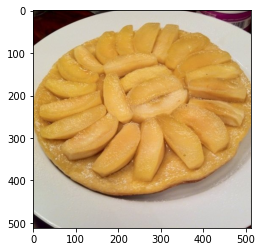

In [53]:
for image_features in ds_parsed.take(1):
  image_raw = image_features['image_raw'].numpy()
  #https://stackoverflow.com/questions/49511753/python-byte-image-to-numpy-array-using-opencv
  image = np.array(PIL.Image.open(io.BytesIO(image_raw))) 
  plt.imshow(image)  

# Test, train, validation splits

https://www.v7labs.com/blog/train-validation-test-set


In [39]:
# https://stackoverflow.com/questions/51125266/how-do-i-split-tensorflow-datasets
train_size = int(0.7 * ds_size)
val_size = int(0.15 * ds_size)
test_size = int(0.15 * ds_size)

full_dataset = tf.data.TFRecordDataset(raw_image_dataset)
full_dataset = full_dataset.shuffle(ds_size)
train_dataset = full_dataset.take(train_size)
test_dataset = full_dataset.skip(train_size)
val_dataset = test_dataset.skip(test_size)
test_dataset = test_dataset.take(test_size)

# Create the CNN